In [9]:
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import astropy.units as u

In [2]:
#decals_splus = Table.read('GalfitM_sex_DECALS_SPLUS_17_xmatch.csv')
#decals_splus

In [42]:
model = Table.read('GalfitM_DECALS_SPLUS_25.csv', format='ascii')
splus = Table.read('/home/seba/Documents/CG/MorphoPLUS_SFCGs/Morphoplus_groups/Catalogos_try/GalfitM_output_final_3.csv', format='ascii')
#s = splus.group_by('Group')
#keys = s.groups.keys
#print(keys)
#splus_26 = splus[splus['Group']==26]
#splus = splus[np.argsort(splus['Gal'])]
#model_235 = model[model['Group']==235]
#model_235
model = model[(model['mag_g_2'] < 19) & (model['mag_r_2'] < 19) & (model['mag_i_2'] < 19) & (model['mag_z_2'] < 19)]
splus = splus[(splus['MAG_G'] < 19) & (splus['MAG_R'] < 19) & (splus['MAG_I'] < 19) & (splus['MAG_Z'] < 19) ]
len(model)

80

In [43]:
# Mostrar los nombres de las columnas antes del cambio
#print("Nombres de columnas antes del cambio:", splus.colnames)

# Definir las columnas que deseas cambiar
columnas_a_cambiar = ['n_R', 'n_G', 'n_I', 'n_Z', 'RE_R', 'RE_G', 'RE_I', 'RE_Z', 'MAG_R', 'MAG_G', 'MAG_I', 'MAG_Z']

# Crear un diccionario para mapear los nombres antiguos a los nuevos solo para las columnas específicas
column_mapping = {col: re.sub(r'_(G|R|I|Z)', lambda x: f'_{x.group(1).lower()}', col) for col in columnas_a_cambiar}

# Renombrar las columnas en la tabla
for old_name, new_name in column_mapping.items():
    if old_name in splus.colnames:
        splus.rename_column(old_name, new_name)
print(splus.colnames)

['Group', 'Gal', 'ID', 'CHI2NU', 'XC_R', 'e_XC_R', 'YC_R', 'e_YC_R', 'MAG_r', 'e_MAG_R', 'RE_r', 'e_RE_R', 'n_r', 'e_n_R', 'AR_R', 'e_AR_R', 'PA_R', 'e_PA_R', 'XC_J0378', 'e_XC_J0378', 'YC_J0378', 'e_YC_J0378', 'MAG_J0378', 'e_MAG_J0378', 'RE_J0378', 'e_RE_J0378', 'n_J0378', 'e_n_J0378', 'AR_J0378', 'e_AR_J0378', 'PA_J0378', 'e_PA_J0378', 'XC_J0395', 'e_XC_J0395', 'YC_J0395', 'e_YC_J0395', 'MAG_J0395', 'e_MAG_J0395', 'RE_J0395', 'e_RE_J0395', 'n_J0395', 'e_n_J0395', 'AR_J0395', 'e_AR_J0395', 'PA_J0395', 'e_PA_J0395', 'XC_J0410', 'e_XC_J0410', 'YC_J0410', 'e_YC_J0410', 'MAG_J0410', 'e_MAG_J0410', 'RE_J0410', 'e_RE_J0410', 'n_J0410', 'e_n_J0410', 'AR_J0410', 'e_AR_J0410', 'PA_J0410', 'e_PA_J0410', 'XC_J0430', 'e_XC_J0430', 'YC_J0430', 'e_YC_J0430', 'MAG_J0430', 'e_MAG_J0430', 'RE_J0430', 'e_RE_J0430', 'n_J0430', 'e_n_J0430', 'AR_J0430', 'e_AR_J0430', 'PA_J0430', 'e_PA_J0430', 'XC_J0515', 'e_XC_J0515', 'YC_J0515', 'e_YC_J0515', 'MAG_J0515', 'e_MAG_J0515', 'RE_J0515', 'e_RE_J0515', 'n_J051

In [44]:
filtros = ['g', 'r', 'i', 'z']
#filtros_splus = ['G', 'R', 'I', 'Z']
for filtro in filtros:        
    model['n_' + filtro] = pd.to_numeric(model['n_' + filtro], errors='coerce')
    model['RE_' +filtro] = pd.to_numeric(model['RE_' + filtro], errors = 'coerce')
for fil in filtros:
    splus['n_' + fil] = pd.to_numeric(splus['n_' + fil], errors='coerce')
    splus['RE_' +fil] = pd.to_numeric(splus['RE_' + fil], errors = 'coerce')
    splus['MAG_' +fil] = pd.to_numeric(splus['MAG_' + fil], errors = 'coerce')
    


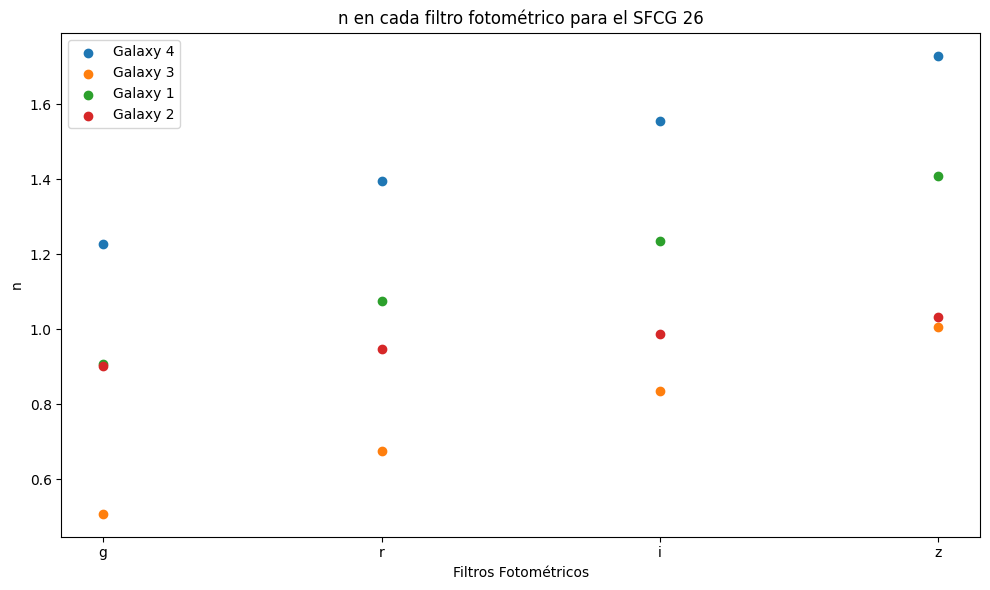

In [5]:
#Para el grupo 235
model_26 = model[model['Group']==26]
# Lista de filtros fotométricos
filtros = ['g', 'r', 'i', 'z']

# Supongamos que sersic es un DataFrame de pandas
# Asegúrate de que sersic tenga las mismas columnas que filtros
# Si las columnas no están en el mismo orden que los filtros, ajusta el orden
valores_sersic = np.array([model_26['n_' + filtro] for filtro in filtros])

# Crear el gráfico de puntos
plt.figure(figsize=(10, 6))
for i in range(len(model_26)):
    gal = model['Gal'][i]
    plt.scatter(filtros, valores_sersic[:, i], label=f'Galaxy {gal}')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros)  # Etiquetas del eje x
plt.xlabel('Filtros Fotométricos')
plt.ylabel('n')
plt.title('n en cada filtro fotométrico para el SFCG 26')
plt.legend()
plt.tight_layout()
plt.ylim()

# Mostrar el gráfico
plt.show()

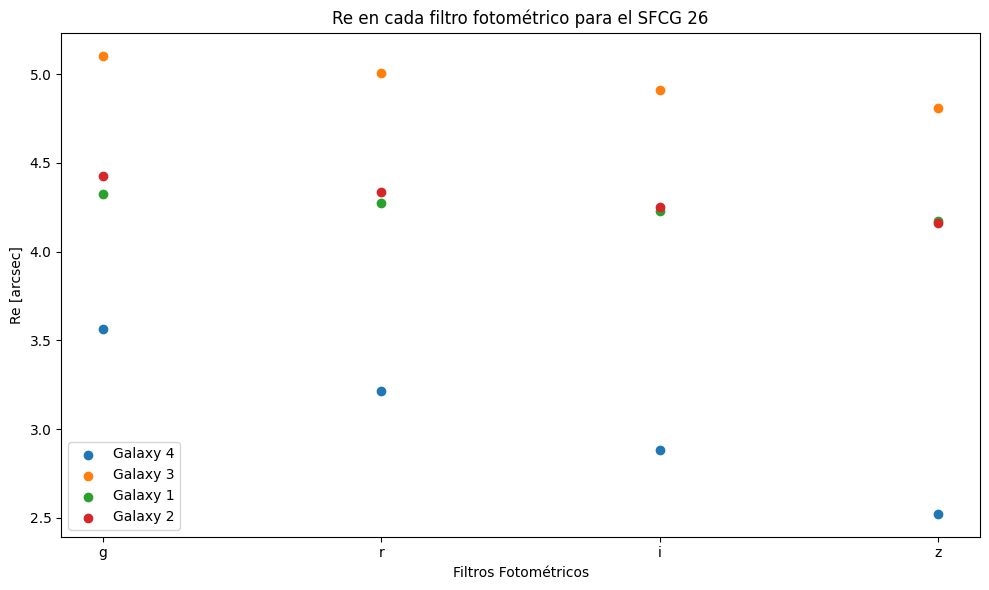

In [6]:
# Lista de filtros fotométricos
filtros = ['g', 'r', 'i', 'z']

# Supongamos que sersic es un DataFrame de pandas
# Asegúrate de que sersic tenga las mismas columnas que filtros
# Si las columnas no están en el mismo orden que los filtros, ajusta el orden
valores_re = np.array([model_26['RE_' + filtro] for filtro in filtros])

# Crear el gráfico de puntos
plt.figure(figsize=(10, 6))
for i in range(len(model_26)):
    gal = model_26['Gal'][i]
    #print(filtros)
    #print(valores_sersic[:, i])
    #print()
    plt.scatter(filtros, valores_re[:, i]*0.262, label=f'Galaxy {gal}')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros)  # Etiquetas del eje x
plt.xlabel('Filtros Fotométricos')
plt.ylabel('Re [arcsec]')
plt.title('Re en cada filtro fotométrico para el SFCG 26')
plt.legend()
plt.tight_layout()
plt.ylim()

# Mostrar el gráfico
plt.show()

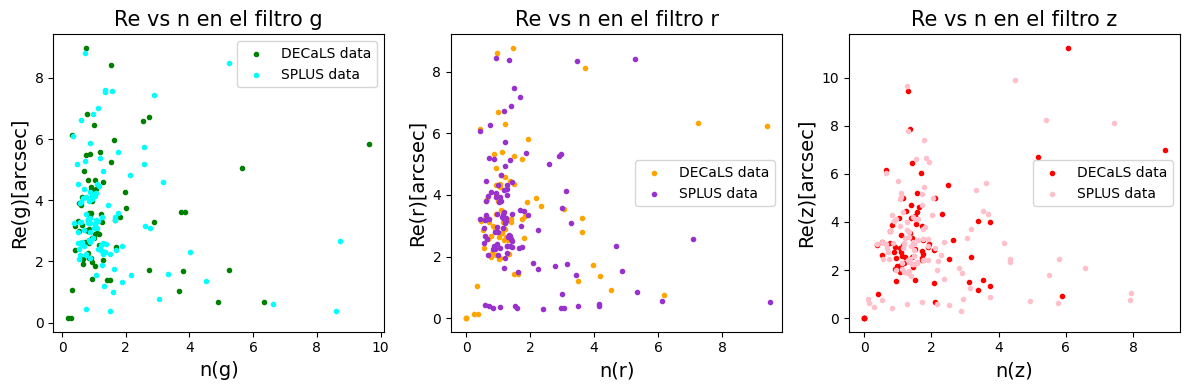

In [36]:
# Función para graficar Re vs n en grz.
def graficar_re_n(axs, archivo, color_g, color_r, color_z, label, pixel_scale):
    
    # Convertir las columnas de interés a tipos de datos numéricos
    for filtro in filtros:
        archivo['n_' + filtro] = pd.to_numeric(archivo['n_' + filtro], errors='coerce')
        archivo['RE_' +filtro] = pd.to_numeric(archivo['RE_' + filtro], errors = 'coerce')
    
    axs[0].scatter(archivo['n_g'], archivo['RE_g']*pixel_scale, label=label, color=color_g, marker='.')
    axs[0].set_xlabel('n(g)', fontsize = 14)
    axs[0].set_ylabel('Re(g)[arcsec]', fontsize=14)
    axs[0].set_title(f'Re vs n en el filtro g', fontsize=15)
    axs[0].set_xlim()
    axs[0].set_ylim()

    axs[1].scatter(archivo['n_r'], archivo['RE_r']*pixel_scale, label=label, color=color_r, marker='.')
    axs[1].set_xlabel('n(r)', fontsize = 14)
    axs[1].set_ylabel('Re(r)[arcsec]', fontsize=14)
    axs[1].set_title(f'Re vs n en el filtro r', fontsize=15)
    axs[1].set_xlim()
    axs[1].set_ylim()

    axs[2].scatter(archivo['n_z'], archivo['RE_z']*pixel_scale, label=label, color=color_z, marker='.')
    axs[2].set_xlabel('n(z)', fontsize = 14)
    axs[2].set_ylabel('Re(z)[arcsec]', fontsize=14)
    axs[2].set_title(f'Re vs n en el filtro z', fontsize=15)
    axs[2].set_xlim()
    axs[2].set_ylim()
    
    # Añadir leyenda en cada sub-gráfico
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Graficar
graficar_re_n(axs[:], model, 'green', 'orange', 'red', 'DECaLS data', 0.262)
graficar_re_n(axs[:], splus, 'cyan', 'darkorchid', 'pink', 'SPLUS data', 0.55)
# Ajustar diseño y mostrar gráficos
plt.legend()
plt.tight_layout()
plt.show()

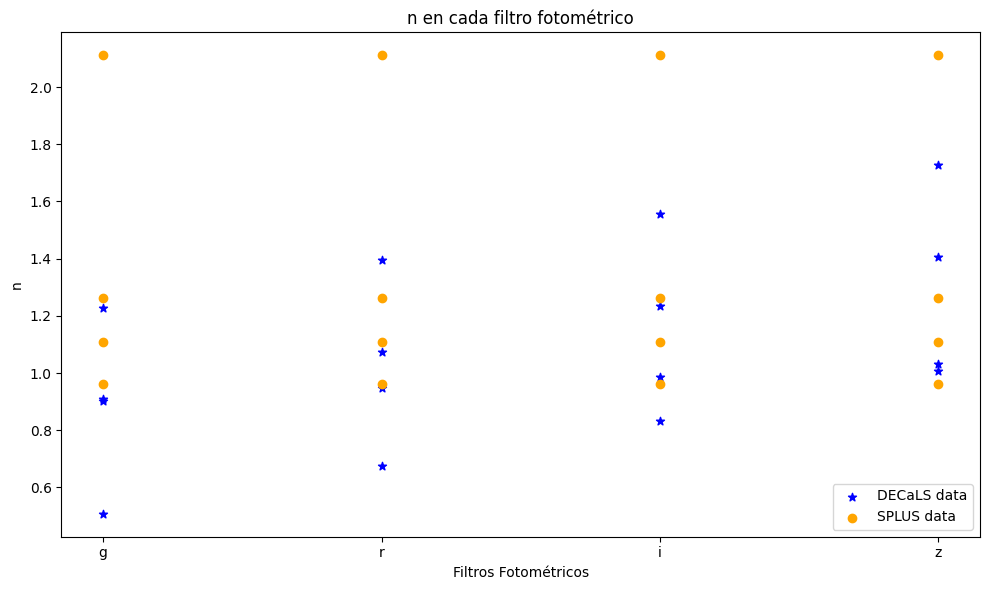

In [8]:
#Comparación entre ambos surveys para el grupo 235
splus_26 = splus[splus['Group'] == 26]

# Lista de filtros fotométricos
filtros = ['g', 'r', 'i', 'z']

# Convertir las columnas de interés a tipos de datos numéricos
for filtro in filtros:
    splus['n_' + filtro] = pd.to_numeric(splus['n_' + filtro], errors='coerce')
    #splus['MAG_' +filtro] = pd.to_numeric(splus['MAG_' + filtro], errors = 'coerce')
# Si las columnas no están en el mismo orden que los filtros, ajusta el orden
valores_sersic = np.array([model_26['n_' + filtro] for filtro in filtros])
valores_sersic_splus = np.array([splus_26['n_'+fil] for filtro in filtros])

# Convertir las columnas 'Gal' a Series de pandas
galaxias_model = pd.Series(model_26['Gal'])
galaxias_splus = pd.Series(splus_26['Gal'])

# Crear diccionario para mapear cada número de galaxia a un color único
galaxias = pd.concat([galaxias_model, galaxias_splus]).unique()
colores = plt.cm.rainbow(np.linspace(0, 1, len(galaxias)))
color_dict = {galaxia: color for galaxia, color in zip(galaxias, colores)}

# Crear el gráfico de puntos
plt.figure(figsize=(10, 6))
for i in range(len(model_26)):
    gal = model_26['Gal'][i]
    color = color_dict[gal]
    plt.scatter(filtros, valores_sersic[:, i], marker='*', color='blue', label=f'DECaLS data')
    
for i in range(len(splus_26)):
    gal = splus_26['Gal'][i]
    color = color_dict[gal]
    plt.scatter(filtros, valores_sersic_splus[:, i], marker='o', color='orange', label='SPLUS data')
# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros)  # Etiquetas del eje x
plt.xlabel('Filtros Fotométricos')
plt.ylabel('n')
plt.title('n en cada filtro fotométrico')
#plt.legend()

# Evitar duplicados en la leyenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')

plt.tight_layout()

# Mostrar el gráfico
plt.show()

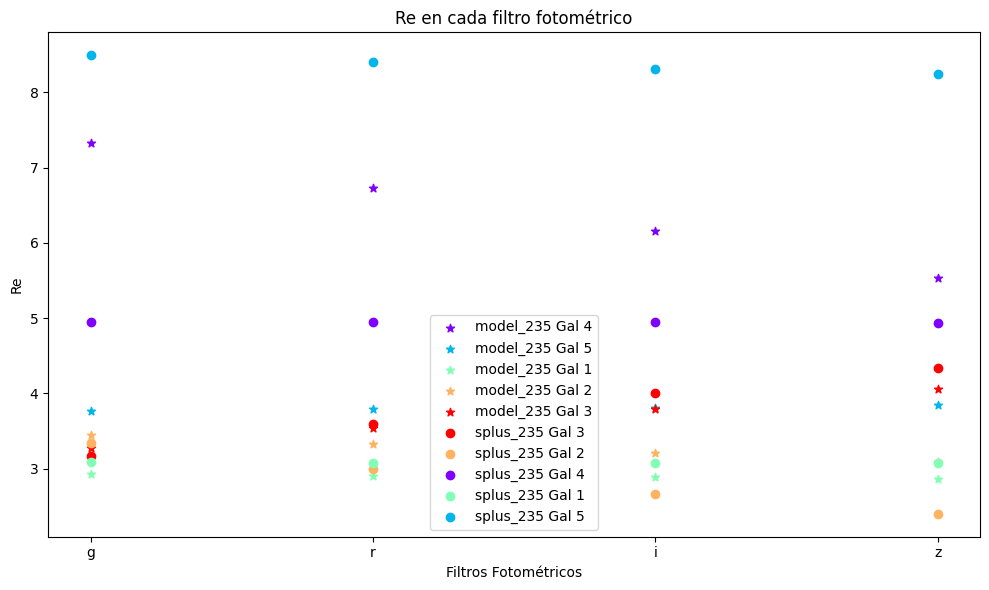

In [55]:
# Si las columnas no están en el mismo orden que los filtros, ajusta el orden
valores_re = np.array([model_235['RE_' + filtro] for filtro in filtros])
valores_re_splus = np.array([splus_235['RE_'+filtro] for filtro in filtros])

# Convertir las columnas 'Gal' a Series de pandas
galaxias_model = pd.Series(model_235['Gal'])
galaxias_splus = pd.Series(splus_235['Gal'])

# Crear diccionario para mapear cada número de galaxia a un color único
galaxias = pd.concat([galaxias_model, galaxias_splus]).unique()
colores = plt.cm.rainbow(np.linspace(0, 1, len(galaxias)))
color_dict = {galaxia: color for galaxia, color in zip(galaxias, colores)}

# Crear el gráfico de puntos
plt.figure(figsize=(10, 6))
for i in range(len(model_235)):
    gal = model_235['Gal'][i]
    color = color_dict[gal]
    plt.scatter(filtros, valores_re[:, i]*0.262, marker='*', color=color, label=f'model_235 Gal {gal}')
    
for i in range(len(splus_235)):
    gal = splus_235['Gal'][i]
    color = color_dict[gal]
    plt.scatter(filtros, valores_re_splus[:, i]*0.55, marker='o', color=color, label=f'splus_235 Gal {gal}')
# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros)  # Etiquetas del eje x
plt.xlabel('Filtros Fotométricos')
plt.ylabel('Re')
plt.title('Re en cada filtro fotométrico')
#plt.legend()

# Evitar duplicados en la leyenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')

plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [45]:
valores_sersic = np.array([model['n_' + filtro] for filtro in filtros])
valores_sersic_splus = np.array([splus['n_'+filtro] for filtro in filtros])
# Función para calcular la mediana sin NaN y ceros
def calcular_mediana_sin_nan_ni_ceros(valores):
    # Filtrar NaN y ceros
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0)]
    if len(valores_filtrados) > 0:
        return np.median(valores_filtrados)
    else:
        return np.nan

# Calcular medianas para cada filtro en 'valores_sersic'
medianas_valores_sersic = np.array([calcular_mediana_sin_nan_ni_ceros(valores_sersic[i]) for i in range(len(filtros))])

# Calcular medianas para cada filtro en 'valores_sersic_splus'
medianas_valores_sersic_splus = np.array([calcular_mediana_sin_nan_ni_ceros(valores_sersic_splus[i]) for i in range(len(filtros))])

# Imprimir resultados
print("Medianas para valores_sersic:")
print(medianas_valores_sersic)

print("\nMedianas para valores_sersic_splus:")
print(medianas_valores_sersic_splus)                                


Medianas para valores_sersic:
[0.953  1.1655 1.3639 1.4535]

Medianas para valores_sersic_splus:
[1.1365 1.2712 1.4291 1.5542]


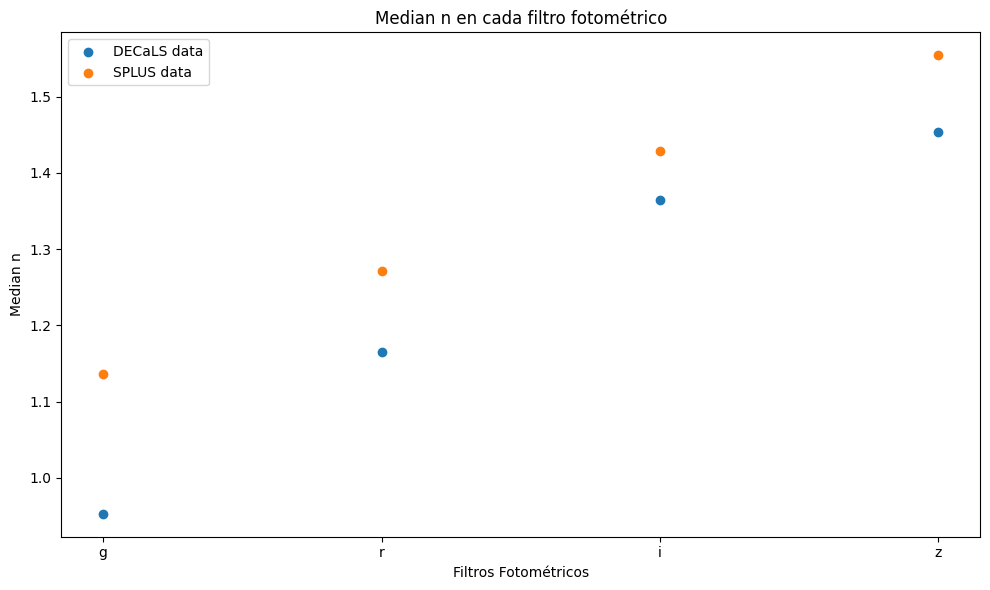

In [46]:
# Crear el gráfico de puntos
plt.figure(figsize=(10, 6))

plt.scatter(filtros, medianas_valores_sersic, label='DECaLS data')
plt.scatter(filtros, medianas_valores_sersic_splus, label='SPLUS data')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros)  # Etiquetas del eje x
plt.xlabel('Filtros Fotométricos')
plt.ylabel('Median n')
plt.title('Median n en cada filtro fotométrico')
#plt.legend()

plt.legend()

plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [47]:
valores_re = np.array([model['RE_' + filtro] for filtro in filtros])
valores_re_splus = np.array([splus['RE_'+filtro] for filtro in filtros])
# Función para calcular la mediana sin NaN y ceros
def calcular_mediana_sin_nan_ni_ceros(valores):
    # Filtrar NaN y ceros
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0)]
    if len(valores_filtrados) > 0:
        return np.median(valores_filtrados)
    else:
        return np.nan

# Calcular medianas para cada filtro en 'valores_sersic'
medianas_valores_re = np.array([calcular_mediana_sin_nan_ni_ceros(valores_re[i]) for i in range(len(filtros))])

# Calcular medianas para cada filtro en 'valores_sersic_splus'
medianas_valores_re_splus = np.array([calcular_mediana_sin_nan_ni_ceros(valores_re_splus[i]) for i in range(len(filtros))])

# Imprimir resultados
print("Medianas para valores_re:")
print(medianas_valores_re*0.262)

print("\nMedianas para valores_re_splus:")
print(medianas_valores_re_splus*0.55)
print(len(valores_re))

Medianas para valores_re:
[3.2851656 3.1880029 3.116883  3.0264799]

Medianas para valores_re_splus:
[3.279375 3.20331  3.124055 3.0734  ]
4


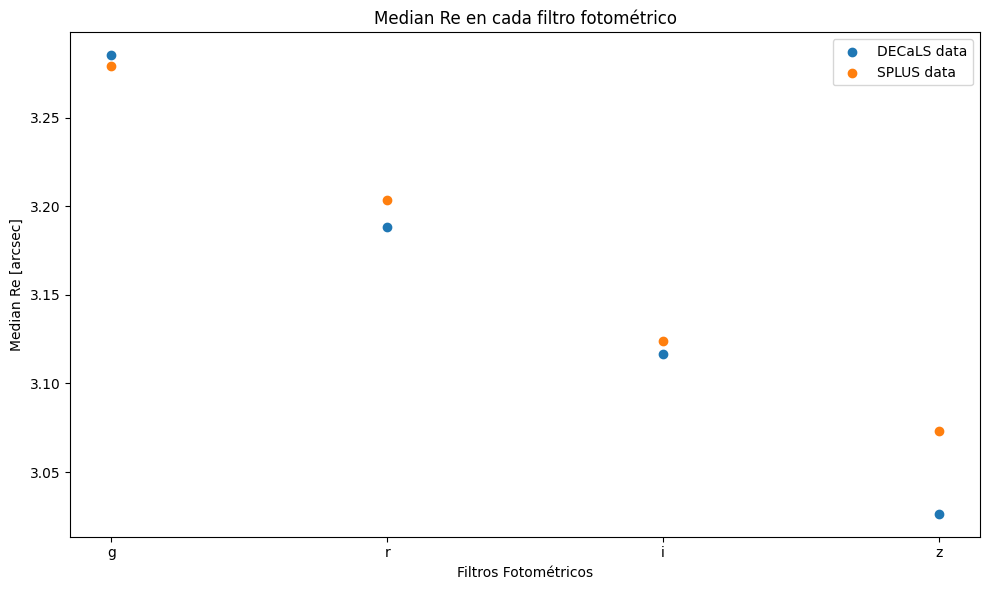

In [48]:
# Crear el gráfico de puntos
plt.figure(figsize=(10, 6))

plt.scatter(filtros, medianas_valores_re*0.262, label='DECaLS data')
plt.scatter(filtros, medianas_valores_re_splus*0.55, label='SPLUS data')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros)  # Etiquetas del eje x
plt.xlabel('Filtros Fotométricos')
plt.ylabel('Median Re [arcsec]')
plt.title('Median Re en cada filtro fotométrico')
#plt.legend()

plt.legend()

plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [86]:
# Obtener los grupos únicos en la tabla model
model_groups = set(model['Group'])

# Filtrar la tabla splus para que contenga solo los grupos presentes en model
filtered_splus = splus[np.isin(splus['Group'], list(model_groups))]


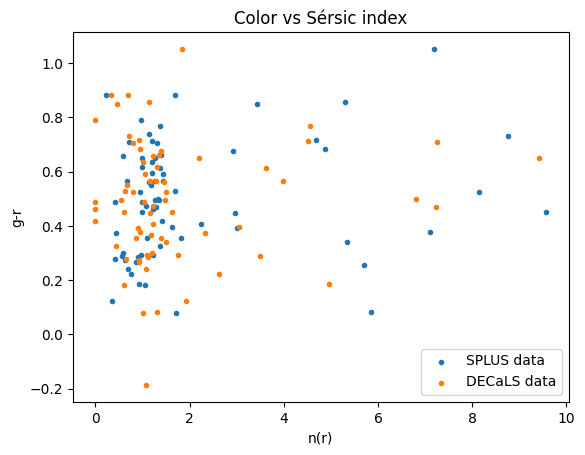

In [87]:
u_r_o = filtered_splus['MAG_g'] - filtered_splus['MAG_r']
g_r_model = model['MAG_g'] - model['MAG_r']
plt.scatter(filtered_splus['n_r'], u_r_o, marker='.', label='SPLUS data')
plt.scatter(model['n_r'], u_r_o, marker='.', label='DECaLS data')

#plt.ylim(-3, 5)
#plt.xlim(0, )
plt.title('Color vs Sérsic index')
plt.xlabel('n(r)')
plt.ylabel('g-r')
# Añadir una línea horizontal en y=50
plt.legend()
#plt.axhline(y=2.3, color='r', linestyle='--')

# Añadir una línea vertical en x=5
#plt.axvline(x=2.5, color='g', linestyle='--')
plt.show()

In [2]:
decals_data = Table.read('GalfitM_DECALS_SPLUS_25.csv')
filtros = ['g', 'r', 'i', 'z']
#filtros_splus = ['G', 'R', 'I', 'Z']
for filtro in filtros:        
    decals_data['n_' + filtro] = pd.to_numeric(decals_data['n_' + filtro], errors='coerce')
    decals_data['RE_' +filtro] = pd.to_numeric(decals_data['RE_' + filtro], errors = 'coerce')

In [3]:
grouped_decals = decals_data.group_by('Group_1')

valid_groups=[]

for group in grouped_decals.groups:
    if any (group['zmemb'] != 0):
        valid_groups.append(group['Group_1'][0])

filtered_table = decals_data[np.isin(decals_data['Group_1'], valid_groups)]
filtered_table

Group_1,Gal_1,ID,ra_1,dec_1,type_1,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g_1,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r_1,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i_1,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z_1,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ra_2,dec_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g_2,mag_r_2,mag_i_2,mag_z_2,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,Group_2,Gal_2,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,Simbad,Separation_2,Separation
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,float64
20,1,1471,13.04012577583562,-1.119177251059751,SER,0.550881294713299,756.9186,0.002,659.4763,0.0047,34.2949,0.0154,16.5489,0.0005,0.7657,0.0009,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,32.8672,0.0116,15.8441,0.0003,0.9628,0.0006,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,31.505,0.0134,15.5299,0.0003,1.1508,0.0007,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,30.0303,0.0195,15.2787,0.0005,1.3544,0.0013,0.2277,0.0001,-23.0521,0.0058,324660,0131m010,1471,SER,13.04012577583562,-1.119177251059751,0.051570516,230.60197,448.92276,636.275,798.9123,1.2603335,1.2122216,1.1767341,1.1621677,1.057419,1638754.4,8.487607,247327.45,0.43531945,54462148.0,-0.45720544,54293176.0,16.592842,15.869571,15.490888,15.243752,15.001912,15.345359,13.093337,12.205332,0.72327137,0.3786831,0.62581825,0.24713516,13.0404167,-1.1191389,20,1,00 52 09.70,-01 07 08.9,0.041238,--,19.5171,18.6617,Simbad,1.0561898463173114,0.0
20,3,1935,13.04660065707238,-1.128448197229796,EXP,0.550881294713299,676.7578,0.0047,519.8303,0.0034,13.8501,0.0278,17.9135,0.0018,1.2425,0.0039,0.6732,0.0005,-64.1641,0.0925,676.7578,0.0047,519.8303,0.0034,12.7863,0.0145,17.4785,0.001,1.3475,0.0020,0.6732,0.0005,-64.1641,0.0925,676.7578,0.0047,519.8303,0.0034,11.7714,0.0170,17.2249,0.0012,1.4478,0.0029,0.6732,0.0005,-64.1641,0.0925,676.7578,0.0047,519.8303,0.0034,10.6727,0.0325,17.1916,0.0025,1.5562,0.0053,0.6732,0.0005,-64.1641,0.0925,323220,0131m012,1935,EXP,13.04660065707238,-1.128448197229796,0.051507268,3.4392571,3.2952976,3.358729,2.7863362,1.2609787,1.2108105,1.1729822,1.1568494,1.0,0.0,2.0052536,2357.357,-0.2930719,10150.253,-0.35053492,11807.057,21.158838,21.205263,21.184563,21.387417,--,--,--,--,-0.046424866,0.020700455,-0.1821537,-0.20285416,13.0462083,-1.1287222,20,3,00 52 11.09,-01 07 43.4,0.104819,--,19.9696,18.953,Simbad,1.7225985663573806,0.0
20,2,1536,13.04231588811046,-1.109083549669928,REX,0.550881294713299,723.3525,0.0038,783.534,0.0051,2.8661,0.0112,19.7399,0.0022,1.0814,0.0223,0.5483,0.0021,12.1869,0.2279,723.3525,0.0038,783.534,0.0051,3.0283,0.0066,19.4675,0.0018,1.1854,0.0108,0.5483,0.0021,12.1869,0.2279,723.3525,0.0038,783.534,0.0051,3.1832,0.0103,19.3441,0.0025,1.2846,0.0159,0.5483,0.0021,12.1869,0.2279,723.3525,0.0038,783.534,0.0051,3.3508,0.0180,19.2356,0.004,1.392,0.0308,0.5483,0.0021,12.1869,0.2279,324660,0131m010,1536,REX,13.04231588811046,-1.10908

In [4]:
# Crear una función para reemplazar los valores de 'zmemb' que son 0
def replace_zeros(group):
    non_zero_values = group['zmemb'][group['zmemb'] != 0]
    if len(non_zero_values) > 0:
        replacement_value = non_zero_values[0]
        group['zmemb'] = np.where(group['zmemb'] == 0, replacement_value, group['zmemb'])
    return group

# Aplicar la función a cada grupo y unir los resultados
result_groups = []
for group in filtered_table.group_by('Group_1').groups:
    result_groups.append(replace_zeros(group))

final_table = vstack(result_groups)

final_table

Group_1,Gal_1,ID,ra_1,dec_1,type_1,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g_1,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r_1,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i_1,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z_1,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ra_2,dec_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g_2,mag_r_2,mag_i_2,mag_z_2,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,Group_2,Gal_2,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,Simbad,Separation_2,Separation
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,float64
20,1,1471,13.04012577583562,-1.119177251059751,SER,0.550881294713299,756.9186,0.002,659.4763,0.0047,34.2949,0.0154,16.5489,0.0005,0.7657,0.0009,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,32.8672,0.0116,15.8441,0.0003,0.9628,0.0006,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,31.505,0.0134,15.5299,0.0003,1.1508,0.0007,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,30.0303,0.0195,15.2787,0.0005,1.3544,0.0013,0.2277,0.0001,-23.0521,0.0058,324660,0131m010,1471,SER,13.04012577583562,-1.119177251059751,0.051570516,230.60197,448.92276,636.275,798.9123,1.2603335,1.2122216,1.1767341,1.1621677,1.057419,1638754.4,8.487607,247327.45,0.43531945,54462148.0,-0.45720544,54293176.0,16.592842,15.869571,15.490888,15.243752,15.001912,15.345359,13.093337,12.205332,0.72327137,0.3786831,0.62581825,0.24713516,13.0404167,-1.1191389,20,1,00 52 09.70,-01 07 08.9,0.041238,--,19.5171,18.6617,Simbad,1.0561898463173114,0.0
20,3,1935,13.04660065707238,-1.128448197229796,EXP,0.550881294713299,676.7578,0.0047,519.8303,0.0034,13.8501,0.0278,17.9135,0.0018,1.2425,0.0039,0.6732,0.0005,-64.1641,0.0925,676.7578,0.0047,519.8303,0.0034,12.7863,0.0145,17.4785,0.001,1.3475,0.0020,0.6732,0.0005,-64.1641,0.0925,676.7578,0.0047,519.8303,0.0034,11.7714,0.0170,17.2249,0.0012,1.4478,0.0029,0.6732,0.0005,-64.1641,0.0925,676.7578,0.0047,519.8303,0.0034,10.6727,0.0325,17.1916,0.0025,1.5562,0.0053,0.6732,0.0005,-64.1641,0.0925,323220,0131m012,1935,EXP,13.04660065707238,-1.128448197229796,0.051507268,3.4392571,3.2952976,3.358729,2.7863362,1.2609787,1.2108105,1.1729822,1.1568494,1.0,0.0,2.0052536,2357.357,-0.2930719,10150.253,-0.35053492,11807.057,21.158838,21.205263,21.184563,21.387417,--,--,--,--,-0.046424866,0.020700455,-0.1821537,-0.20285416,13.0462083,-1.1287222,20,3,00 52 11.09,-01 07 43.4,0.104819,--,19.9696,18.953,Simbad,1.7225985663573806,0.0
20,2,1536,13.04231588811046,-1.109083549669928,REX,0.550881294713299,723.3525,0.0038,783.534,0.0051,2.8661,0.0112,19.7399,0.0022,1.0814,0.0223,0.5483,0.0021,12.1869,0.2279,723.3525,0.0038,783.534,0.0051,3.0283,0.0066,19.4675,0.0018,1.1854,0.0108,0.5483,0.0021,12.1869,0.2279,723.3525,0.0038,783.534,0.0051,3.1832,0.0103,19.3441,0.0025,1.2846,0.0159,0.5483,0.0021,12.1869,0.2279,723.3525,0.0038,783.534,0.0051,3.3508,0.0180,19.2356,0.004,1.392,0.0308,0.5483,0.0021,12.1869,0.2279,324660,0131m010,1536,REX,13.04231588811046,-1.10908

$log SFR_{NUV} (M_{\odot}yr^{-1}) = log L_{NUV}, corr(L_{\odot}) -9.33$


$log SFR_{FUV} (M_{\odot}yr^{-1}) = log L_{FUV}, corr(L_{\odot}) -9.51$

$A_{NUV} = -0.0495x^{3} + 0.4718x^{2} + 0.8998x + 0.2269$

$A_{FUV} = -0.0333y^{3} + 0.3522y^{2} + 1.1960y + 0.4967$


In [5]:
H_0 = 67.4 #km/s/Mpc
c = 300000
final_table['Distance (Mpc)'] = (final_table['zmemb']*c)/H_0
final_table

Group_1,Gal_1,ID,ra_1,dec_1,type_1,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g_1,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r_1,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i_1,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z_1,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ra_2,dec_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g_2,mag_r_2,mag_i_2,mag_z_2,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,Group_2,Gal_2,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,Simbad,Separation_2,Separation,Distance (Mpc)
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,float64,float64
20,1,1471,13.04012577583562,-1.119177251059751,SER,0.550881294713299,756.9186,0.002,659.4763,0.0047,34.2949,0.0154,16.5489,0.0005,0.7657,0.0009,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,32.8672,0.0116,15.8441,0.0003,0.9628,0.0006,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,31.505,0.0134,15.5299,0.0003,1.1508,0.0007,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,30.0303,0.0195,15.2787,0.0005,1.3544,0.0013,0.2277,0.0001,-23.0521,0.0058,324660,0131m010,1471,SER,13.04012577583562,-1.119177251059751,0.051570516,230.60197,448.92276,636.275,798.9123,1.2603335,1.2122216,1.1767341,1.1621677,1.057419,1638754.4,8.487607,247327.45,0.43531945,54462148.0,-0.45720544,54293176.0,16.592842,15.869571,15.490888,15.243752,15.001912,15.345359,13.093337,12.205332,0.72327137,0.3786831,0.62581825,0.24713516,13.0404167,-1.1191389,20,1,00 52 09.70,-01 07 08.9,0.041238,--,19.5171,18.6617,Simbad,1.0561898463173114,0.0,183.55192878338278
20,3,1935,13.04660065707238,-1.128448197229796,EXP,0.550881294713299,676.7578,0.0047,519.8303,0.0034,13.8501,0.0278,17.9135,0.0018,1.2425,0.0039,0.6732,0.0005,-64.1641,0.0925,676.7578,0.0047,519.8303,0.0034,12.7863,0.0145,17.4785,0.001,1.3475,0.0020,0.6732,0.0005,-64.1641,0.0925,676.7578,0.0047,519.8303,0.0034,11.7714,0.0170,17.2249,0.0012,1.4478,0.0029,0.6732,0.0005,-64.1641,0.0925,676.7578,0.0047,519.8303,0.0034,10.6727,0.0325,17.1916,0.0025,1.5562,0.0053,0.6732,0.0005,-64.1641,0.0925,323220,0131m012,1935,EXP,13.04660065707238,-1.128448197229796,0.051507268,3.4392571,3.2952976,3.358729,2.7863362,1.2609787,1.2108105,1.1729822,1.1568494,1.0,0.0,2.0052536,2357.357,-0.2930719,10150.253,-0.35053492,11807.057,21.158838,21.205263,21.184563,21.387417,--,--,--,--,-0.046424866,0.020700455,-0.1821537,-0.20285416,13.0462083,-1.1287222,20,3,00 52 11.09,-01 07 43.4,0.104819,--,19.9696,18.953,Simbad,1.7225985663573806,0.0,466.55341246290794
20,2,1536,13.04231588811046,-1.109083549669928,REX,0.550881294713299,723.3525,0.0038,783.534,0.0051,2.8661,0.0112,19.7399,0.0022,1.0814,0.0223,0.5483,0.0021,12.1869,0.2279,723.3525,0.0038,783.534,0.0051,3.0283,0.0066,19.4675,0.0018,1.1854,0.0108,0.5483,0.0021,12.1869,0.2279,723.3525,0.0038,783.534,0.0051,3.1832,0.0103,19.3441,0.0025,1.2846,0.0159,0.5483,0.0021,12.1869,0.2279,723.3525,0.0038,783.534,0.0051,3.3508,0.0180,19.2356,0.004,1.392,0.0308,0.5483,0.0021,12.18

### Para calcular magnitud absoluta, utilizamos el módulo de distancia
$m - M = 5log(\frac{D}{1pc}) - 5$
### Para luego obtener la Luminosidad mediante
$L_{x} = 10^{-0.4(M_{x}-M_{\odot, x})}L_{\odot, x}$

### O también con flujo
$m_{x} = -2.5log(F) - 48.6$

## $F = 10^{-\frac{(m_{x} + 48.6)}{2.5}}$

$L = 4\pi D^2 F$


In [7]:
final_table['M_FUV'] = final_table['FUV'] - 5*np.log10(final_table['Distance (Mpc)']*1000000) + 5
final_table['M_NUV'] = final_table['NUV'] - 5*np.log10(final_table['Distance (Mpc)']*1000000) + 5
#Contiene transformación de sistema de referencia de Vega a AB
final_table['M_w3'] = final_table['mag_w3']+5.174 - 5*np.log10(final_table['Distance (Mpc)']*1000000) + 5

eta_fuv = 1.98e+15
eta_nuv = 1.32e+15
eta_w3 = 2.5e+13


final_table['F_FUV'] = 10**(-(final_table['FUV']+48.6)/2.5)*eta_fuv
final_table['F_NUV'] = 10**(-(final_table['NUV']+48.6)/2.5)*eta_nuv
final_table['F_w3'] = 10**(-((final_table['mag_w3']+5.174)+48.6)/2.5)*eta_w3

In [8]:
M_sun_FUV = 16.42
M_sun_NUV = 10.31
M_sun_w3 = 8.48
#L_sun_FUV = 1.5*10e27*(u.erg/u.s)
#L_sun_NUV = 8.6*10e27*(u.erg/u.s)
#L_sun_w3 = 1.3*10e30*(u.erg/u.s)
L_sun = 3.83*10**33
f_sun = 10**(-0.4*(-26.76+48.6))*5.45e+14
l_sun = 4*np.pi*((1.52e+13)**2)*f_sun


#final_table['L_FUV'] = 10**(-0.4*(final_table['M_FUV'] - M_sun_FUV))*L_sun
#final_table['L_NUV'] = 10**(-0.4*(final_table['M_NUV'] - M_sun_NUV))*L_sun
#final_table['L_w3'] = 10**(-0.4*(final_table['M_w3'] - M_sun_w3))*L_sun
final_table['L_FUV_2'] = 4*np.pi*((final_table['Distance (Mpc)']*3.086*10**24)**2)*final_table['F_FUV']
final_table['L_NUV_2'] = 4*np.pi*((final_table['Distance (Mpc)']*3.086*10**24)**2)*final_table['F_NUV']
final_table['L_w3_2'] = 4*np.pi*((final_table['Distance (Mpc)']*3.086*10**24)**2)*final_table['F_w3']
l_sun

2.9059861639132555e+33

In [16]:
# Función para verificar si un valor es numérico
def is_number(value):
    try:
        float(value)
        return True
    except (ValueError, TypeError):
        return False

# Convertir los valores enmascarados a string y eliminar espacios en blanco
final_table['mag_w3'] = [str(x).strip() for x in final_table['mag_w3']]

# Crear una máscara booleana para los valores numéricos
mask = [is_number(x) for x in final_table['mag_w3']]

# Aplicar la máscara para filtrar la tabla
final_table = final_table[mask]

# Convertir la columna a tipo flotante
final_table['mag_w3'] = final_table['mag_w3'].astype(float)

# Eliminar filas con valores NaN
final_table = final_table[~np.isnan(final_table['mag_w3'])]

# Eliminar filas con valores infinitos
final_table = final_table[np.isfinite(final_table['mag_w3'])]

# Mostrar la tabla resultante
final_table

Group_1,Gal_1,ID,ra_1,dec_1,type_1,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g_1,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r_1,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i_1,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z_1,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ra_2,dec_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g_2,mag_r_2,mag_i_2,mag_z_2,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,Group_2,Gal_2,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,Simbad,Separation_2,Separation,Distance (Mpc),M_FUV,M_NUV,M_w3,F_FUV,F_NUV,F_w3,L_FUV_2,L_NUV_2,L_w3_2
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,str8,float64,float64,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object
20,1,1471,13.04012577583562,-1.119177251059751,SER,0.550881294713299,756.9186,0.002,659.4763,0.0047,34.2949,0.0154,16.5489,0.0005,0.7657,0.0009,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,32.8672,0.0116,15.8441,0.0003,0.9628,0.0006,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,31.505,0.0134,15.5299,0.0003,1.1508,0.0007,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,30.0303,0.0195,15.2787,0.0005,1.3544,0.0013,0.2277,0.0001,-23.0521,0.0058,324660,0131m010,1471,SER,13.04012577583562,-1.119177251059751,0.051570516,230.60197,448.92276,636.275,798.9123,1.2603335,1.2122216,1.1767341,1.1621677,1.057419,1638754.4,8.487607,247327.45,0.43531945,54462148.0,-0.45720544,54293176.0,16.592842,15.869571,15.490888,15.243752,15.001912,15.345359,13.093337,12.205332,0.72327137,0.3786831,0.62581825,0.24713516,13.0404167,-1.1191389,20,1,00 52 09.70,-01 07 08.9,0.041238,--,19.5171,18.6617,Simbad,1.0561898463173114,0.0,183.55192878338278,-16.80169476238523,-17.65709476238523,-18.05145776238523,1.1215669167128568e-12,1.6439701633615704e-12,4.477186738180435e-14,4.522148322196049e+42,6.628473794300774e+42,1.8051979061187444e+41
20,2,1536,13.04231588811046,-1.109083549669928,REX,0.550881294713299,723.3525,0.0038,783.534,0.0051,2.8661,0.0112,19.7399,0.0022,1.0814,0.0223,0.5483,0.0021,12.1869,0.2279,723.3525,0.0038,783.534,0.0051,3.0283,0.0066,19.4675,0.0018,1.1854,0.0108,0.5483,0.0021,12.1869,0.2279,723.3525,0.0038,783.534,0.0051,3.1832,0.0103,19.3441,0.0025,1.2846,0.0159,0.5483,0.0021,12.1869,0.2279,723.3525,0.0038,783.534,0.0051,3.3508,0.0180,19.2356,0.004,1.392,0.0308,0.5483,0.0021,12.1869,0.2279,324660,0131m010,1536,REX,13.04231588811046,-1.109083549669928,0.051510766,0.25799054,0.4023387,0.48846605,0.14988658,1.2603335,1.2122216,1.1767341,1.1717132,1.0,0.0,1.2333512,88.353714,0.0,0.0,0.0,0.0,23.970991,23.48852,23.277914,24.560593,--,--,17.390049,--,0.48247147,0.21060562,-1.072073,-1.2826786,13.0429583,-1.1094444,20,2,00 52 10.31,-01 06 34.0,0.041238,--,19.9459,20.2035,Simbad,2.6521797133342666,0.0,183.55192878338278,-16.37289476238523,-16.115294762385233,-13.75474576238523,7.556230375042816e-13,3.9735065312756605e-13,8.556977867060815e-16,3.0466656963077114e+42,1.602114472697453e+42,3.450166238677

In [17]:
SFR_NUV=[]
SFR_FUV=[]
L=[]
for i in range(len(final_table)):
    #Razón entre L_IR y L_FUV, NUV para la correción por polvo
    x_nuv = np.log10(final_table['L_w3_2'][i]/final_table['L_NUV_2'][i])
    y_fuv = np.log10(final_table['L_w3_2'][i]/final_table['L_FUV_2'][i])
    #Calculando A_nuv y A_fuv 
    a_nuv = -0.0495*x_nuv**3 + 0.4718*x_nuv**2 + 0.8998*x_nuv + 0.2269
    a_fuv = -0.0333*y_fuv**3 + 0.3522*y_fuv**2 + 1.1960*y_fuv + 0.4967
    #Calculando la magnitud absoluta corregida por polvo
    F_FUV = 10**(-((final_table['FUV'][i] - a_fuv) + 48.6)/2.5)*eta_fuv
    F_NUV = 10**(-((final_table['NUV'][i] - a_nuv) + 48.6)/2.5)*eta_nuv
    #Calculando la Luminosidad corregida en L_sun (por eso no se multiplica por L_sun)
    L_FUV_cor = 4*np.pi*((final_table['Distance (Mpc)'][i]*3.086e+24)**2)*F_FUV/L_sun
    L_NUV_cor = 4*np.pi*((final_table['Distance (Mpc)'][i]*3.086e+24)**2)*F_NUV/L_sun
    L.append(L_FUV_cor)
    #Calculando la SFR en FUV y NUV
    sfr_FUV = np.log10(L_FUV_cor) - 9.51
    sfr_NUV = np.log10(L_NUV_cor) - 9.33
    
    SFR_NUV.append(sfr_NUV)
    SFR_FUV.append(sfr_FUV)

final_table['logSFR_NUV'] = SFR_NUV
final_table['logSFR_FUV'] = SFR_FUV
np.median(SFR_NUV)

0.7717788306948341

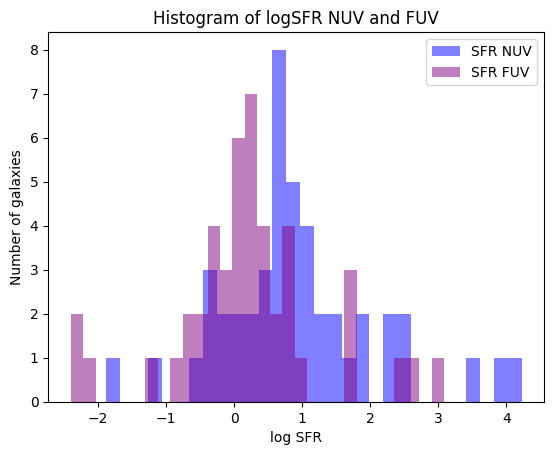

In [18]:
# Suponiendo que 'final_table' y 'final_table_z' son tus tablas
data1 = SFR_NUV
data2 = SFR_FUV

# Crear el histograma con transparencia
plt.hist(data1, bins=30, alpha=0.5, label='SFR NUV', color='blue')
plt.hist(data2, bins=30, alpha=0.5, label='SFR FUV', color='purple')

# Agregar etiquetas y título
plt.xlabel('log SFR')
plt.ylabel('Number of galaxies')
plt.title('Histogram of logSFR NUV and FUV')

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()